## Content
### 1 Data Collection
1.1 Data crawling using crawler.py  
1.2 Obtaining jd description and adding job type labels
### 2 Preprocessing
2.1 Read in and combine all data  
2.2 Operations on Description
### 3 Modeling
3.1 Three methods on input data  
- CountVectoerizer
- TFIDF
- TFIDF+SVD

3.2 Three models for classification and evaluation
- Naive Bayes
- SVM with parameter tuning
- Logistic regression
3.3 Selected best model

### 4 Suggestoin and Recommentation System with demo
4.1 Job classification  
4.2 Suggestion system using keywords.py  
4.3 Recommendation system using KNN

## 1 Data Collection

### 1.1 Data crawling using crawler.py  

In [37]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import requests
import re
import time
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36',
        'Connection': 'close'}

In [7]:
import crawler

In [3]:
# joblist contains the target six job types
joblist = ['Financial+Analyst', 'Consultancy', 'Business+Manager', 'Data+Analyst','Engineers', 'Designer']
for key in joblist:
    crawler.LinkedInData(key).getBasic()

Financial+Analyst finished crawling
Consultancy finished crawling
Business+Manager finished crawling
Data+Analyst finished crawling
Engineers finished crawling
Designer finished crawling


### 1.2 Obtaining jd description and adding job type labels

In [10]:
def getr(job_link):
    """function to get job link website content
    
    response.text: help to check whether the request is succeeded
    """
    time.sleep(3)
    response = requests.get(url=job_link, headers=headers)
    if not response.ok:
        print(response.ok)
    res = response.text
    r = BeautifulSoup(res,'lxml')
    return(r)


def getjd(r):
    """function to get job description
    
    return the jd description content in bullet form of the job description web
    """
    jd = None
    deses = r.find('div', class_='show-more-less-html__markup')
    if deses:
        tmp = [item.text.strip() for item in deses.find_all('li')]
        jd = '; '.join(tmp)
    return jd


def index_assign(criname, cri_list):
    """function to check positions of criteria: Seniority level,Employment type,Job function,Industries
    Since these four attributes are not displayed orderly when some of them are missing,
    function here is used to correcly assign the attributes
    
    return indexes that attributes is non-missing
    """
    index = []
    if 'Seniority level' in criname:
        index.append(0)
    if 'Employment type' in criname:
        index.append(1)
    if 'Job function' in criname:
        index.append(2)
    if 'Industries' in criname:
        index.append(3)
    return(index)


def getcriteria(r):
    """function to get information of four criteria
    cri_totallist: four criteria name
    criconlist_list: criteria values in web
    
    return formatted list with length 4 containing observed values or initial 'Not Applicable' value
    """
    finds = r.find_all('li',class_='description__job-criteria-item')
    cri_totallist = ['Seniority level','Employment type','Job function','Industries']
    criteria = ['Not Applicable', 'Not Applicable', 'Not Applicable', 'Not Applicable']
    cri_list = [find.find('h3', class_="description__job-criteria-subheader").text.strip() for find in finds]
    cricontent_list = [find.find('span', class_="description__job-criteria-text description__job-criteria-text--criteria").text.strip() for find in finds]
    indexes = index_assign(cri_list, cri_totallist)
    for j in range(len(cricontent_list)):
        criteria[indexes[j]] = cricontent_list[j]
    return criteria


def infoOnLink(link):
    """function to combine above functions
    
    return list of length 5 containing job descriptions and criteria content
    """
    r = getr(link)
    jd = getjd(r)
    cri = getcriteria(r)
    return [jd, cri[0], cri[1], cri[2], cri[3]]


def output(keyword):
    """function to 
    1. apply on job dataframe get before to extract an information set 
    of job description and criteria content as expanded columns
    2. add label for each job type
    
    return a new dataframe for each job type with information set as new columns
    """
    linkdf = pd.read_csv(f'{keyword}_links.csv').iloc[:,1:]
    collist = ['Description', 'Seniority level', 'Employment type', 'Job function', 'Industries']
    linkdf[collist] = linkdf.apply(lambda x: infoOnLink(x.Link), axis=1, result_type ='expand')
    linkdf['label'] = f'{keyword.replace("+", "")}'
    print(f'{keyword} finished extracting info')
    linkdf.to_csv(f'{keyword}_data.csv')
    return linkdf

In [12]:
for key in joblist:
    output(key)

Financial+Analyst finished extracting info
Consultancy finished extracting info
Business+Manager finished extracting info
Data+Analyst finished extracting info
Engineers finished extracting info
Designer finished extracting info


## 2 Data Preprocessing

### 2.1 Read in and combine all data

In [66]:
import os

In [70]:
# combine all datasets together
data = pd.DataFrame()
files = os.listdir('.')
for file in files:
    if file.endswith('data.csv'):
        data = data.append(pd.read_csv('%s' % (file)).iloc[:,1:])

In [71]:
# drop nans and duplicated rows
data = data.dropna().drop_duplicates()

In [72]:
data.shape

(3971, 11)

### 2.2 operations on Description

In [73]:
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

stopwords = stopwords.words('english')

In [74]:
def cleantext(text):
    """function to clean the text of Description
    """
    # remove Chinese words
    pattern = r'[\u4e00-\u9fff]+'
    snowball = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    text = re.sub(pattern, " ", text.lower()).strip()
    # remove digits first or error for float numbers
    text = ''.join([i for i in text if not i.isdigit()])
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    clean_words = [lemmatizer.lemmatize(snowball.stem(word), pos='a') for word in words if word not in stopwords]
    return ' '.join(clean_words)

In [75]:
data['words'] = data.Description.astype(str).apply(cleantext)

In [76]:
# export preprocessed data
data.to_csv('preprocessed.csv')

In [77]:
data.head()

,Titile,Company,Location,Date,Link,Description,Seniority level,Employment type,Job function,Industries,label,words
0,Database Analyst Senior,FIS,"Wan Chai District, Hong Kong SAR",2021/9/30,https://hk.linkedin.com/jobs/view/database-ana...,Partner with cross functional teams such as bu...,Mid-Senior level,Full-time,Information Technology,IT Services and IT Consulting and Financial Se...,DataAnalyst,partner cross function team busi oper core pro...
1,Data Analyst (Data Quality and Data Governance),GoAnimate Hong Kong Limited\n,"Hong Kong, Hong Kong SAR",2021/11/10,https://hk.linkedin.com/jobs/view/data-analyst...,Monitor key reporting data sources for anomali...,Not Applicable,Other,Information Technology,IT Services and IT Consulting,DataAnalyst,monitor key report data sourc anomali investig...
2,"Senior System Analyst, Web Applications",Robert Walters,"Hong Kong, Hong Kong SAR",2021/10/25,https://hk.linkedin.com/jobs/view/senior-syste...,Lead junior developers to perform development ...,Associate,Full-time,Information Technology,"IT Services and IT Consulting, Computer Softwa...",DataAnalyst,lead junior develop perform develop system enh...
3,Data Scientist (Leading Logistics Company),Spring Professional,"Hong Kong, Hong Kong SAR",2021/11/1,https://hk.linkedin.com/jobs/view/data-scienti...,Demonstrate a thorough awareness of the demand...,Not Applicable,Full-time,Engineering and Information Technology,IT Services and IT Consulting,DataAnalyst,demonstr thorough awar demand various busi uni...
4,Senior KYC Analyst,Ebury,"Central, Hong Kong SAR",2021/10/26,https://hk.linkedin.com/jobs/view/senior-kyc-a...,"Safeguarding Ebury, our existing Clients and p...",Associate,Full-time,Finance and Sales,Financial Services,DataAnalyst,safeguard eburi exist client prospect client r...


## 3 Modeling

In [78]:
import pandas as pd

In [107]:
# split the dataset into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.words, data.label, test_size=0.2, random_state=1205)

### 3.1 Three methods on input data

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [81]:
def countVec(X):
    """function to do countVectorizer
    """
    vectorizer = CountVectorizer(min_df=100, stop_words='english')
    return vectorizer.fit_transform(X), vectorizer

def tfidf(X):
    """function to do IFIDF transformation
    """
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X), vectorizer

def tfidfSVD(X, svd_cum = 0.85):
    """function to do IFIDF and SVD reduction
    
    svd_cum : expected minimum total explained variance ratio for SVD
    return selected components for SVD, vectorizer for IFIDF, svd transformer
    """
    X_tfidf, vectorizer = tfidf(X)
    svd = TruncatedSVD(n_components=X_tfidf.shape[0])
    X_svd = svd.fit_transform(X_tfidf.toarray())
    ers = svd.explained_variance_ratio_.sum()
    if ers < svd_cum:
        print(f"{svd.n_components} SVD components can explain {ers: .3f} of total variance.")
    else:
        nc = np.argmax(np.cumsum(svd.explained_variance_ratio_) > svd_cum)
        svd = TruncatedSVD(n_components=nc)
        X_svd = svd.fit_transform(X_tfidf)
        ers_new = svd.explained_variance_ratio_.sum()
        print(f"{svd.n_components} SVD components can explain {ers_new: .3f} of total variance.") 
        return X_svd, vectorizer, svd

In [108]:
# apply the above three methods to training dataset
X_cv, vectorizer_cv = countVec(X_train)
X_tfidf, vectorizer_tfidf = tfidf(X_train)
X_tfidf_svd, vectorizer_svd, svd = tfidfSVD(X_train, 0.85)
y = y_train

831 SVD components can explain  0.848 of total variance.


In [83]:
# check the dimension of operated training data
print(f" CounVect: {X_cv.shape}, tfidf: {X_tfidf.shape}, tfidf+SVD: {X_tfidf_svd.shape}, y: {y.shape}")

 CounVect: (3176, 576), tfidf: (3176, 6948), tfidf+SVD: (3176, 831), y: (3176,)


In [84]:
import warnings

# stop scikit-learn's deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 3.2 Three models for classification and evaluation

In [113]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def eval_confusion(clf, X_test, y_pred, y_true, plot=False):
    """function to compute confusion matrix, accuracy, precision, recall and f1 values
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    if plot:
        titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
        for title, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(
                clf,
                X_test,
                y_true,
                cmap=plt.cm.Blues,
                normalize=normalize,
            )
            disp.ax_.set_title(title)
            print(title)
            plt.xticks(rotation=90)
            plt.show()
    return {'matrix': conf_matrix, 'precision': precision, 'recall': recall, 'f1': f1}

In [103]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# classification models
#Naive Bayes
nb_clf = MultinomialNB()
#SVM
svm_clf = SVC()
#Logistic Regression
lr_clf = LogisticRegression()

classifiers = {
    'NB': nb_clf,
    'SVM': svm_clf,
    'Logistic Regression': lr_clf
}

# training data preparation
train_data = {
    'countVectorizer': X_cv,
    'tfidf': X_tfidf,
    'tfidf+SVD': X_tfidf_svd
}

# testing data preparation
X_test_cv = vectorizer_cv.transform(X_test)
X_test_tfidf = vectorizer_tfidf.transform(X_test)
X_test_tfidfsvd = svd.transform(vectorizer_svd.transform(X_test))

test_data = {
    'countVectorizer': X_test_cv,
    'tfidf': X_test_tfidf,
    'tfidf+SVD': X_test_tfidfsvd
}

Confusion matrix, without normalization


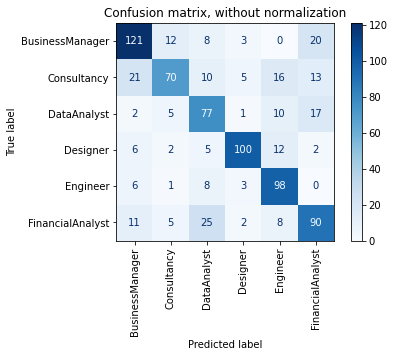

Normalized confusion matrix


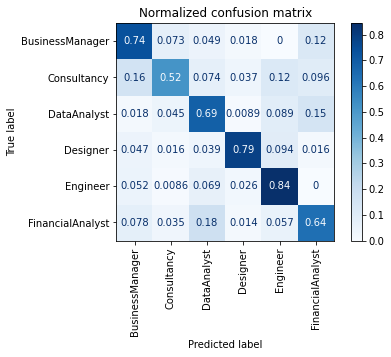

NB: for input using countVectorizer
[[121  12   8   3   0  20]
 [ 21  70  10   5  16  13]
 [  2   5  77   1  10  17]
 [  6   2   5 100  12   2]
 [  6   1   8   3  98   0]
 [ 11   5  25   2   8  90]]
precision: 0.6993710691823899
recall: 0.6993710691823899
f1-score: 0.6993710691823899
accuracy: 0.6993710691823899

Confusion matrix, without normalization


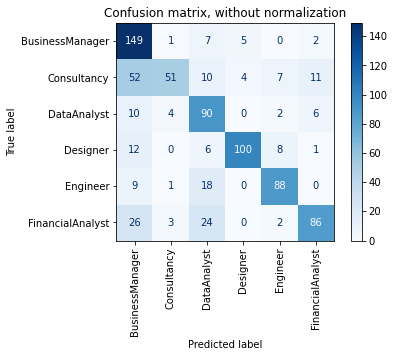

Normalized confusion matrix


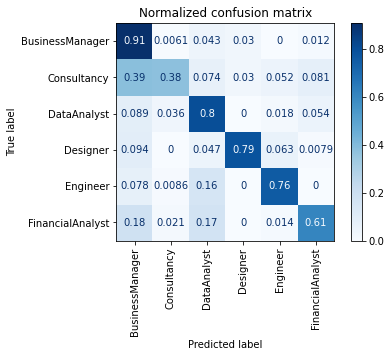

NB: for input using tfidf
[[149   1   7   5   0   2]
 [ 52  51  10   4   7  11]
 [ 10   4  90   0   2   6]
 [ 12   0   6 100   8   1]
 [  9   1  18   0  88   0]
 [ 26   3  24   0   2  86]]
precision: 0.7094339622641509
recall: 0.7094339622641509
f1-score: 0.7094339622641509
accuracy: 0.7094339622641509



In [116]:
# NB
# as there will be negative values in tfidf+SVD, we do not fit NB for tfidf+SVD
for inputType in list(train_data.keys())[:2]:
    nb_clf.fit(train_data[inputType], y_train)
    y_pred = nb_clf.predict(test_data[inputType])
    conf = eval_confusion(nb_clf, test_data[inputType], y_pred, y_test, plot=True)
    print(f'NB: for input using {inputType}')
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
    print()

Confusion matrix, without normalization


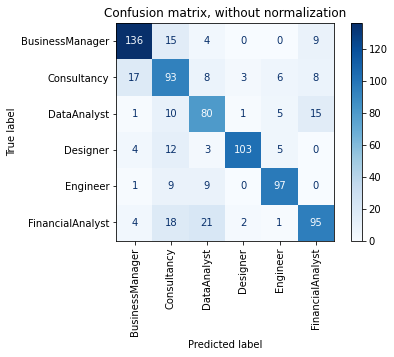

Normalized confusion matrix


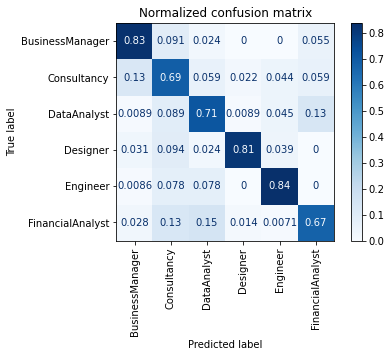

SVM: for input using countVectorizer
[[136  15   4   0   0   9]
 [ 17  93   8   3   6   8]
 [  1  10  80   1   5  15]
 [  4  12   3 103   5   0]
 [  1   9   9   0  97   0]
 [  4  18  21   2   1  95]]
precision: 0.759748427672956
recall: 0.759748427672956
f1-score: 0.7597484276729559
accuracy: 0.759748427672956

Confusion matrix, without normalization


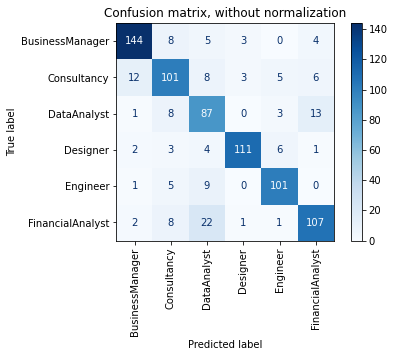

Normalized confusion matrix


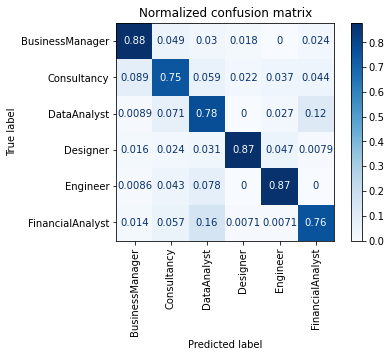

SVM: for input using tfidf
[[144   8   5   3   0   4]
 [ 12 101   8   3   5   6]
 [  1   8  87   0   3  13]
 [  2   3   4 111   6   1]
 [  1   5   9   0 101   0]
 [  2   8  22   1   1 107]]
precision: 0.8188679245283019
recall: 0.8188679245283019
f1-score: 0.8188679245283019
accuracy: 0.8188679245283019

Confusion matrix, without normalization


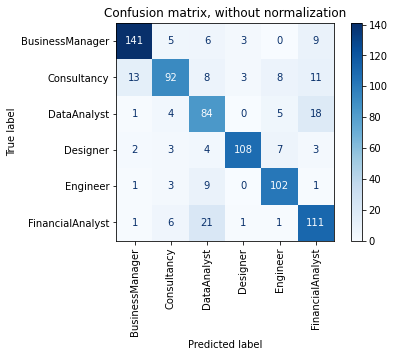

Normalized confusion matrix


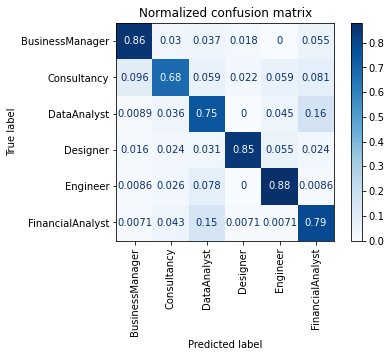

SVM: for input using tfidf+SVD
[[141   5   6   3   0   9]
 [ 13  92   8   3   8  11]
 [  1   4  84   0   5  18]
 [  2   3   4 108   7   3]
 [  1   3   9   0 102   1]
 [  1   6  21   1   1 111]]
precision: 0.8025157232704403
recall: 0.8025157232704403
f1-score: 0.8025157232704403
accuracy: 0.8025157232704403



In [115]:
# SVM
for inputType in train_data.keys():
    svm_clf.fit(train_data[inputType], y_train)
    y_pred = svm_clf.predict(test_data[inputType])
    conf = eval_confusion(svm_clf, test_data[inputType], y_pred, y_test, plot=True)
    print(f'SVM: for input using {inputType}')
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
    print()

/Users/dengrongchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix, without normalization


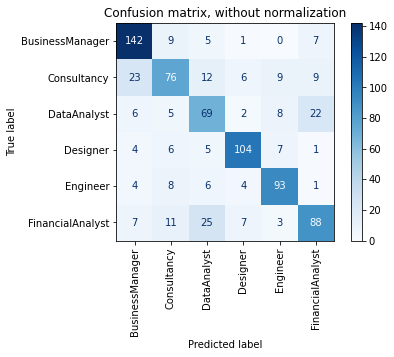

Normalized confusion matrix


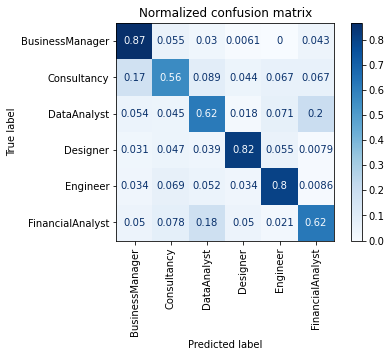

Logistic Regression: for input using countVectorizer
[[142   9   5   1   0   7]
 [ 23  76  12   6   9   9]
 [  6   5  69   2   8  22]
 [  4   6   5 104   7   1]
 [  4   8   6   4  93   1]
 [  7  11  25   7   3  88]]
precision: 0.7194968553459119
recall: 0.7194968553459119
f1-score: 0.719496855345912
accuracy: 0.7194968553459119

Confusion matrix, without normalization


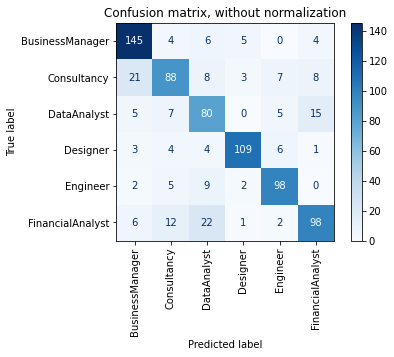

Normalized confusion matrix


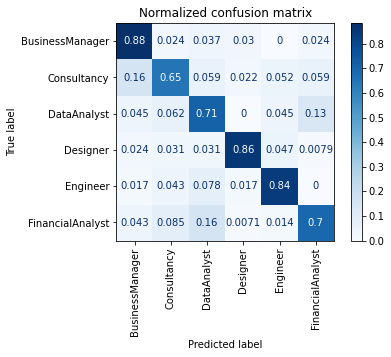

Logistic Regression: for input using tfidf
[[145   4   6   5   0   4]
 [ 21  88   8   3   7   8]
 [  5   7  80   0   5  15]
 [  3   4   4 109   6   1]
 [  2   5   9   2  98   0]
 [  6  12  22   1   2  98]]
precision: 0.7773584905660378
recall: 0.7773584905660378
f1-score: 0.7773584905660378
accuracy: 0.7773584905660378

Confusion matrix, without normalization


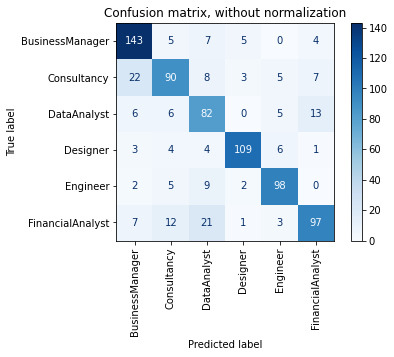

Normalized confusion matrix


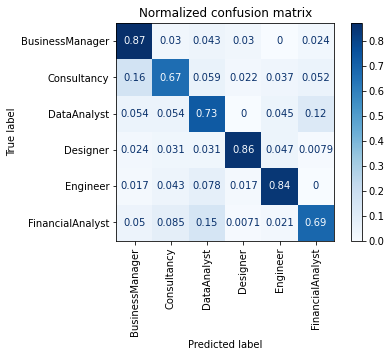

Logistic Regression: for input using tfidf+SVD
[[143   5   7   5   0   4]
 [ 22  90   8   3   5   7]
 [  6   6  82   0   5  13]
 [  3   4   4 109   6   1]
 [  2   5   9   2  98   0]
 [  7  12  21   1   3  97]]
precision: 0.7786163522012579
recall: 0.7786163522012579
f1-score: 0.7786163522012578
accuracy: 0.7786163522012579



In [114]:
# Logistic regression
for inputType in train_data.keys():
    lr_clf.fit(train_data[inputType], y_train)
    y_pred = lr_clf.predict(test_data[inputType])
    conf = eval_confusion(lr_clf, test_data[inputType], y_pred, y_test, plot=True)
    print(f'Logistic Regression: for input using {inputType}')
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
    print()

In [175]:
# fine-tune SVM classifier usinng Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

svm_best = SVC()
svm_param_dist = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
}

svm_randomized_search = RandomizedSearchCV(svm_best, svm_param_dist, n_iter=5, scoring='accuracy',
                                           cv=5, verbose=2, random_state=2021)
svm_randomized_search.fit(X_tfidf, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   6.7s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.7s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.6s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.6s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.9s
[CV] END ....................................C=1, kernel=rbf; total time=   7.7s
[CV] END ....................................C=1, kernel=rbf; total time=   7.6s
[CV] END ....................................C=1, kernel=rbf; total time=   7.5s
[CV] END ....................................C=1, kernel=rbf; total time=   7.3s
[CV] END ....................................C=1, kernel=rbf; total time=   7.5s
[CV] END ...............................C=10, kernel=sigmoid; total time=   3.5s
[CV] END ...............................C=10, ker

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100, 1000],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=2021, scoring='accuracy', verbose=2)

In [178]:
# from the result of fine tuning, we can find that the best model is the same as the default one
# where C=1, kernel='rbf'
svm_randomized_search.best_estimator_

SVC(C=1)

In [46]:
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

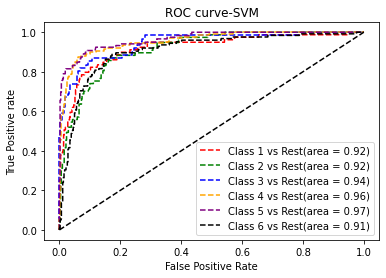

In [34]:
# SVM
clf1 = OneVsRestClassifier(SVC(probability = True))
clf1.fit(X_tfidf, y_train)
pred = clf1.predict(X_test_tfidf)
pred_prob = clf1.predict_proba(X_test_tfidf)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
SVM_roc_auc={}

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    SVM_roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red',label='Class 1 vs Rest(area = %0.2f)'% SVM_roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green',label='Class 2 vs Rest(area = %0.2f)'% SVM_roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 3 vs Rest(area = %0.2f)'% SVM_roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='orange',label='Class 4 vs Rest(area = %0.2f)'% SVM_roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple',label='Class 5 vs Rest(area = %0.2f)'% SVM_roc_auc[4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='black',label='Class 6 vs Rest(area = %0.2f)'% SVM_roc_auc[5])
plt.title('ROC curve-SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

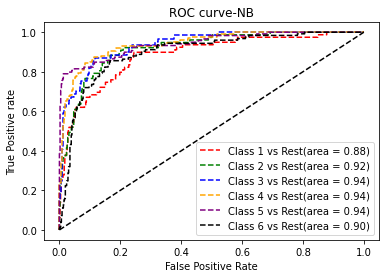

In [36]:
# Naive Bayes
clf2 = OneVsRestClassifier(MultinomialNB())
clf2.fit(X_tfidf, y_train)
pred = clf2.predict(X_test_tfidf)
pred_prob = clf2.predict_proba(X_test_tfidf)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
NB_roc_auc={}

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    NB_roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red',label='Class 1 vs Rest(area = %0.2f)'% NB_roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green',label='Class 2 vs Rest(area = %0.2f)'% NB_roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 3 vs Rest(area = %0.2f)'% NB_roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='orange',label='Class 4 vs Rest(area = %0.2f)'% NB_roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple',label='Class 5 vs Rest(area = %0.2f)'% NB_roc_auc[4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='black',label='Class 6 vs Rest(area = %0.2f)'% NB_roc_auc[5])
plt.title('ROC curve-NB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

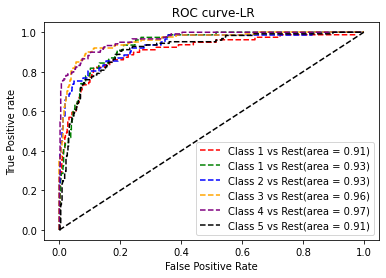

In [32]:
# Logistic Regression
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_tfidf, y_train)
pred = clf.predict(X_test_tfidf)
pred_prob = clf.predict_proba(X_test_tfidf)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
LR_roc_auc={}

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    LR_roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Class 1 vs Rest(area = %0.2f)'% LR_roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest(area = %0.2f)'% LR_roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest(area = %0.2f)'% LR_roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='orange', label='Class 3 vs Rest(area = %0.2f)'% LR_roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest(area = %0.2f)'% LR_roc_auc[4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='black', label='Class 5 vs Rest(area = %0.2f)'% LR_roc_auc[5])
plt.title(' ROC curve-LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

### 3.3 Selected best model

In [37]:
# the best fitted model
svm_best = SVC(C=1, kernel='rbf')
svm_best.fit(train_data['tfidf'], y_train)
y_pred = svm_best.predict(test_data['tfidf'])
print("accuracy: {}".format(accuracy_score(y_pred, y_test)))

accuracy: 0.8188679245283019


## 4 Suggestion and Recommendation system with demo

### 4.1 Job classification

In [117]:
"""demo
rawinput: raw string of resume content from Internet link 
        Resume source: https://www.livecareer.com/resume/examples/graphic-web-design/graphic-designer/entry-level
transinput: preprocessed the input
input_classify: transformed input for model input
"""

rawinput = "Strongly seasoned and hardworking Entry-Level Graphic Designer with extraordinary creative thinking and project design abilities. Adept multitasker with the ability to bring simultaneous graphic design projects to completion with complete efficiency and accuracy. Able to work well independently or as a member of a professional graphic design team. Exceptional sketching and drawing abilities; Superior familiarity with esthetic design concepts and layout principles; Outstanding knowledge of Flash, PowerPoint, Adobe Illustrator, and Photoshop; Excellent creative visualization and design abilities; Strong artistic and technical abilities; High expertise in XML, JavaScript, CSS, PHP, and HTML; Good oral and written communication skills. Design and develop client web sites. Craft custom logos for internet websites per customer specifications. Evaluate final layouts and recommend improvements as necessary on a regular basis. Assist in visual media component creation for film, magazines, and TV. Provide assistance to other graphic design team members as needed. Bachelor’s Degree – Graphic Design 2019 2013 Web Graphic Design Certificate 2013 Graphic Design and Multimedia Certificate"
transinput = [cleantext(rawinput)]
input_classify = vectorizer_tfidf.transform(transinput)

In [41]:
# model to classify to find it is designer
svm_best.predict(input_classify)

array(['Designer'], dtype=object)

### 4.2 Suggestion system using keywords.py  

In [18]:
# import the vocalbulary database
import keywords

wordlist = keywords.keywordsDict()
keyword_dict= wordlist.keywords

In [19]:
def findkeywords(example_words, key_dim, dim):
    """functionn to idenify the matched and missing keywords
    Parameters:
    example_words:   preprocessed words from input. e.g. words in a resume
    key_dim:         keywords in vocabulary database in the dimension of hard or soft skills
    dim:             dimensions of keywords for a job, taking values "Hard Skills" and "Soft Skills: communication+networking"
    
    return lists for matched and missing words with dimension names
    """
    matching_words = []
    matching_words_index = []
    missing_words = []
    missing_words_index = []
    for word in key_dim:
        if word in example_words:
            matching_words.append(word)
            matching_words_index.append(key_dim.index(word))
        else:
            missing_words.append(word)
            missing_words_index.append(key_dim.index(word))
    key_dim = np.array(key_dim)
    return {f'{dim}': list(key_dim[matching_words_index])}, {f'{dim}': list(key_dim[missing_words_index])}

In [20]:
def suggestions(example, keyword_dict, keyword):
    """function to give suggestions as matched and missing keywords of a given resume
    Parameters:
    example:          rawinput of resume content
    keyword_dict:     vocabulary database
    keyword:          classified jobtype
    
    return the matched and missing keywords to screen with readable content
    """
    toke_example = cleantext(example)
    example_words = toke_example.split()
    # extract the keyword dictionary for classified jobtype 'keyword'
    keywords = keyword_dict[keyword]
    dim_list=['Hard Skills', 'Soft Skills: communication+networking']
    matching_words = []
    missing_words = []
    for dim in dim_list:
        maw, miw = findkeywords(example_words, keywords[dim], dim)
        matching_words.append(maw)
        missing_words.append(miw)
    print(f'Congrats! These are what you match for the job as {keyword}: \n', matching_words,'\n')
    print('Further improvement or direction to polish your resume: \n', missing_words)
    return None

In [21]:
suggestions(rawinput, keyword_dict, 'Designer')

Congrats! These are what you match for the job as Designer: 
 [{'Hard Skills': ['design', 'media', 'visual', 'graphic', 'excel', 'photoshop', 'powerpoint', 'xml', 'css']}, {'Soft Skills: communication+networking': ['team', 'client']}] 

Further improvement or direction to polish your resume: 
 [{'Hard Skills': ['product', 'market', 'adobe', 'ux', 'ui', 'autocad', 'figma', 'java']}, {'Soft Skills: communication+networking': ['creative', 'collaborative', 'detail', 'responsible', 'innovative', 'international', 'english', 'chinese', 'mandarin', 'communication', 'user', 'customer']}]


### 4.3 Recommendation system using KNNjob suggestion

In [41]:
# get dataset of classified job category
de_data = data.loc[data['label'] == 'Designer']

In [42]:
from sklearn.neighbors import NearestNeighbors
def recommend_joblink(rawinput, dataset):
    """function to give Top5 suitable jobs
    Parameters:
    rawinput:    a raw string of resume content
    dataset:     classified data category
    
    return Top 5 most suitable jobs
    """
    transinput = [cleantext(rawinput)]
    input1 = svd.transform(vectorizer_svd.transform(transinput))
    de_whole = svd.transform(vectorizer_svd.transform(de_data.words))
    nbrs_de = NearestNeighbors(n_neighbors=5, algorithm = 'ball_tree').fit(de_whole)
    distances_de, indices_de = nbrs_de.kneighbors(input1)
    return de_data.iloc[indices_de[0].tolist(),:5].reset_index().iloc[:,1:]

In [45]:
recommend_joblink(rawinput, de_data)

,Titile,Company,Location,Date,Link
0,Designer,____��_社�_____,"Hong Kong, Hong Kong SAR",2021/11/21,https://hk.linkedin.com/jobs/view/designer-at-...
1,Graphic Designer,Telford International Co Ltd,"Hong Kong, Hong Kong SAR",2021/11/16,https://hk.linkedin.com/jobs/view/graphic-desi...
2,Web and Graphic Designer - Hong Kong,Brinc,"Central & Western District, Hong Kong SAR",2021/9/9,https://hk.linkedin.com/jobs/view/web-and-grap...
3,"UI Designer - mobile app, online food platform",Randstad Hong Kong,"Hong Kong, Hong Kong SAR",2021/10/21,https://hk.linkedin.com/jobs/view/ui-designer-...
4,Creative Director / Art Director,Momax Technology (Hong Kong) Limited,"Hong Kong, Hong Kong SAR",2021/11/5,https://hk.linkedin.com/jobs/view/creative-dir...


In [ ]:
# here the result is different from the demo as we use another seed in apliting training
# and test datasets, then the IFIDF and SVD transformer are different